# 104人力銀行「數據分析師」職缺探索式資料分析
2021/02/14 蘇彥庭

此篇Jupyter Notbook筆記為對104人力銀行「數據分析師」職缺搜尋結果，進行探索式資料分析。

我們希望透過探索式資料分析，能夠了解當前數據分析師的職缺狀況、薪資狀況及所需要的技能等。

分析的資料時點是2021/02/14，透過爬蟲來下載104人力銀行搜尋結果，搜尋關鍵字為「數據分析」，並額外設定職缺更新日期為「最近一個月」及上班時段為「日班」條件，總共下載8個搜尋頁面，共計有160個職缺資料。

此分析的專案程式碼(含此份文件及爬蟲程式碼)皆已上傳至[Github](https://github.com/SuYenTing/104job_data_analyst_analysis)。

In [1]:
# 載入套件及設定
import pandas as pd
import json
import jieba.analyse
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from wordcloud import WordCloud

# 設定matplotlib能夠呈現繁體字
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# 讀取MySQL的數據分析職缺資料
secretFile = json.load(open('secretFile.json', 'r'))
host = secretFile['host']
username = secretFile['user']
password = secretFile['password']
port = secretFile['port']
database = secretFile['dbName']
engine = create_engine(f'mysql+mysqlconnector://{username}:{password}@{host}:{port}/{database}', echo=False)
data = pd.read_sql('select * from search_data', con=engine)
engine.dispose()

In [3]:
# 資料集內容
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   searchTime          160 non-null    object
 1   keyword             160 non-null    object
 2   maxPage             160 non-null    int64 
 3   jobAnnounceDate     160 non-null    object
 4   jobTitles           160 non-null    object
 5   jobCompanyName      160 non-null    object
 6   jobCompanyUrl       160 non-null    object
 7   jobCompanyIndustry  160 non-null    object
 8   jobContent          160 non-null    object
 9   jobCategory         160 non-null    object
 10  jobSalary           160 non-null    object
 11  jobLocation         160 non-null    object
 12  jobRqYear           160 non-null    object
 13  jobRqEducation      160 non-null    object
 14  jobRqDepartment     160 non-null    object
 15  jobSpecialty        160 non-null    object
 16  jobOthers           160 no

## 資料欄位說明

爬蟲下來的資料共計有160筆，共計有18個欄位：

|編號|英文欄位名稱|中文欄位名稱|
|:--:|:--:|:--:|
|1|searchTime|爬蟲執行的時間|
|2|keyword|搜尋關鍵字|
|3|maxPage|搜尋最大頁數|
|4|jobAnnounceDate|職缺日期|
|5|jobTitles|職缺名稱|
|6|jobCompanyName|職缺公司名稱|
|7|jobCompanyUrl|職缺公司網址簡介(104人力銀行頁面)|
|8|jobCompanyIndustry|職缺公司所屬產業|
|9|jobContent|職缺內容|
|10|jobCategory|職缺職業類別|
|11|jobSalary|職缺薪水|
|12|jobLocation|職缺地點|
|13|jobRqYear|職缺要求年資|
|14|jobRqEducation|職缺要求教育程度|
|15|jobRqDepartment|職缺要求系所|
|16|jobSpecialty|職缺要求技能|
|17|jobOthers|職缺其他條件|
|18|jobDetailUrl|職缺詳細資訊(104人力銀行頁面)|

## 資料清洗與整理

為能夠做出品質好的探索式資料分析，此處會先檢查資料，將不合理的資料先行移除，或將資料進行轉換以利分析。

此處程式共處理以下事情：

* 移除重複的職缺: 由於觀察資料時發現有重複資料 疑似有公司重複Po出職缺 所以此處透過「職缺其他條件」來過濾重複資料
* 移除非正職的職缺: 非正職的職缺並非本篇文章想要觀察的目標
* 移除提供年薪資訊的職缺: 由於年薪可能涵蓋到年終，換算出來的月薪會比實際高，造成資料偏頗，所以先移除不做分析
* 移除非本國職缺: 外派職缺的薪資通常會比本國高，此處我們僅觀察本國的薪資
* 整理職缺薪資資訊: 由於薪資會以「月薪35,000至40,000元以上」、「待遇面議」等形式表達，為能夠做量化分析，此處需要先將文字格式轉為數值格式。轉換規則為:
    * 若薪資為一個範圍，例如「月薪35,000至50,000元以上」，則取範圍的上下界值做平均，代表該職缺的薪資
    * 若薪資為某個值以上，例如「月薪50,000元以上」，則直接以該值作為該職缺的薪資
    * 若薪資為「待遇面議」，則直接將薪資令為0，在計算相關薪資分析資料時會排除「待遇面議」資料

In [4]:
# 移除重複職缺
data = data.drop_duplicates(['jobOthers'])
print('移除重複職缺後剩餘資料筆數: ', len(data))

移除重複職缺後剩餘資料筆數:  113


In [5]:
# 移除非正職職缺
data = data[~data['jobTitles'].str.contains('實習|工讀生|兼職')]
data = data[~data['jobSalary'].str.contains('時薪')]
print('移除重複非正值職缺後剩餘資料筆數: ', len(data))

移除重複非正值職缺後剩餘資料筆數:  111


In [6]:
# 移除非本國的職缺
# 台灣縣市清單
taiwanCounties = ['台北', '新北', '宜蘭', '基隆', '桃園', '新竹', '苗栗', 
                  '台中', '彰化', '南投', '雲林', '嘉義', '台南', '高雄', 
                  '屏東', '台東', '花蓮', '澎湖', '金門', '連江']
data = data[data['jobLocation'].str.contains('|'.join(taiwanCounties))]
print('移除非台灣職缺後剩餘資料筆數: ', len(data))

移除非台灣職缺後剩餘資料筆數:  111


In [7]:
# 移除年薪計算的職缺
data = data[~data['jobSalary'].str.contains('年薪')]
print('移除年薪計算職缺後剩餘資料筆數: ', len(data))

移除年薪計算職缺後剩餘資料筆數:  108


In [8]:
# 重新編排index
data = data.reset_index(drop=True)

In [9]:
# 檢查資料表資訊
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   searchTime          108 non-null    object
 1   keyword             108 non-null    object
 2   maxPage             108 non-null    int64 
 3   jobAnnounceDate     108 non-null    object
 4   jobTitles           108 non-null    object
 5   jobCompanyName      108 non-null    object
 6   jobCompanyUrl       108 non-null    object
 7   jobCompanyIndustry  108 non-null    object
 8   jobContent          108 non-null    object
 9   jobCategory         108 non-null    object
 10  jobSalary           108 non-null    object
 11  jobLocation         108 non-null    object
 12  jobRqYear           108 non-null    object
 13  jobRqEducation      108 non-null    object
 14  jobRqDepartment     108 non-null    object
 15  jobSpecialty        108 non-null    object
 16  jobOthers           108 no

In [10]:
# 職缺薪資資料清洗函數
def cleanJobSalary(rawSalary):
    
    # 移除千分位和單位
    rawSalary = rawSalary.replace(',', '').replace('元', '').replace('以上', '')
    
    # 計算月平均薪資
    if '月薪' in rawSalary:
        
        rawSalary = rawSalary.replace('月薪', '')
        rawSalary = rawSalary.split('~')
        
        # 若長度為1代表此薪資資料為某個值以上
        if len(rawSalary) == 1:
            salary = int(rawSalary[0])
        
        # 若長度為2代表此薪資資料為範圍
        elif len(rawSalary) == 2:
            salary = int((int(rawSalary[0]) + int(rawSalary[1]))/2)
        
    elif '待遇面議' in rawSalary:
        salary = int(0)
    
    return(salary)

# 新增整理好的薪資資料
data = data.assign(salary=data['jobSalary'].apply(lambda x: cleanJobSalary(x)))

In [11]:
# 薪資待遇面議樣本數
print('總資料筆數:{}'.format(len(data)))
print('「待遇面議」資料筆數:{} 佔總資料比:{:.2%}'.format(sum(data['salary'] == 0), sum(data['salary'] == 0)/len(data)))
print('「有提供薪資資訊」資料筆數:{} 佔總資料比:{:.2%}'.format(sum(data['salary'] > 0), sum(data['salary'] > 0)/len(data)))

總資料筆數:108
「待遇面議」資料筆數:63 佔總資料比:58.33%
「有提供薪資資訊」資料筆數:45 佔總資料比:41.67%


## 薪資-敘述統計學分析

由敘述統計學分析可以看到，數據分析師的相關職缺的平均薪資為48,189元，中位數為45,000元。

依照法律規定，月薪須達4萬以上才能夠在職缺資訊上寫待遇面議。

但此處的敘述統計學分析並未納入「待遇面議」的樣本，僅計算有提供薪資資訊的樣本(45筆)，所以這邊計算出來的數值結果僅提供參考。

count       45.000000
mean     48188.888889
std      10993.432383
min      30000.000000
25%      42000.000000
50%      45000.000000
75%      54000.000000
max      80000.000000
Name: salary, dtype: float64


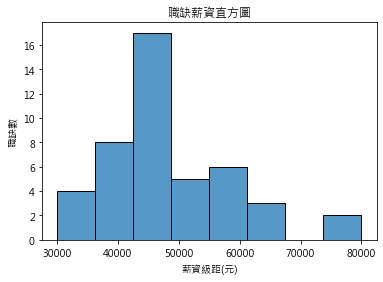

In [12]:
# 薪資敘述統計學分析與直方圖(排除薪資為待遇面議的樣本)
print(data['salary'][data['salary'] > 0].describe())
fig = sns.histplot(data['salary'][data['salary'] > 0])
fig.set(xlabel='薪資級距(元)', ylabel='職缺數', title='職缺薪資直方圖')
plt.show(fig)

## 前10名最需要數據分析的產業

In [13]:
# 前10名職缺所屬職業類別
companyIndustryData = pd.DataFrame({"次數": data['jobCompanyIndustry'].value_counts(), 
                                    "比率%": round(data['jobCompanyIndustry'].value_counts(normalize=True), 4)*100})
companyIndustryData.index.names = ['公司所屬產業類別']
companyIndustryData.head(10)

,次數,比率%
公司所屬產業類別,,
網際網路相關業,21,19.44
電腦軟體服務業,15,13.89
電腦系統整合服務業,10,9.26
銀行業,10,9.26
其它軟體及網路相關業,4,3.70
廣告行銷公關業,4,3.70
金融控股業,4,3.70
工商顧問服務業,4,3.70
百貨相關業,3,2.78


## 前10名數據分析職缺所屬的職業類別

In [14]:
# 前10名職缺所屬職業類別
categoryData = pd.DataFrame({"次數": data['jobCategory'].str.split(',').explode().value_counts(), 
                             "比率%": round(data['jobCategory'].str.split(',').explode().
                                          value_counts(normalize=True), 4)*100})
categoryData.index.names = ['職缺所屬職業類別']
categoryData.head(10)

,次數,比率%
職缺所屬職業類別,,
電腦系統分析師,44,16.18
市場調查／市場分析,37,13.60
軟體設計工程師,34,12.50
其他資訊專業人員,17,6.25
統計精算人員,13,4.78
統計學研究員,13,4.78
資料庫管理人員,12,4.41
其他專案管理師,12,4.41
軟體相關專案管理師,11,4.04


## 薪情最好前10名職業類別

In [15]:
# 薪情最好前10名職業類別(排除薪資為待遇面議的樣本)
catAndSalData = data[data['salary']>0][['jobCategory', 'salary']]
catAndSalData['jobCategory'] = catAndSalData['jobCategory'].str.split(',')
catAndSalData = catAndSalData.explode('jobCategory')
catAndSalData = catAndSalData.groupby('jobCategory').agg(meanSalary=('salary', 'mean'), samples=('salary', 'size'))
catAndSalData = catAndSalData[catAndSalData['samples'] >= 5]  # 計算樣本數需大於5筆
catAndSalData['meanSalary'] = catAndSalData['meanSalary'].astype(int)
catAndSalData['ratio'] = round(catAndSalData['samples']/sum(catAndSalData['samples']), 4)*100
catAndSalData.columns = ['平均薪資', '計算樣本數', '比率(%)']
catAndSalData.index.names = ['職業類別']
catAndSalData.sort_values('平均薪資', ascending=False).head(10)

,平均薪資,計算樣本數,比率(%)
職業類別,,,
統計學研究員,57500,6,7.23
統計精算人員,52416,6,7.23
電腦系統分析師,52361,18,21.69
軟體相關專案管理師,52285,7,8.43
軟體設計工程師,51928,14,16.87
市場調查／市場分析,44923,13,15.66
資料庫管理人員,43500,5,6.02
其他專案管理師,42857,7,8.43
行銷企劃人員,40785,7,8.43


## 職缺地點前10名

計算台灣各縣市「數據分析」(需Python程式設計)的職缺數，可看出大部分的職缺皆集中在台北地區。

In [16]:
# 職缺地點前10名
data['jobLocation'].str.slice(0, 3).value_counts().to_frame('次數').rename_axis('工作地點').reset_index()

# 前10名職缺所屬職業類別
locationData = pd.DataFrame({"次數": data['jobLocation'].str.slice(0, 3).value_counts(),
                             "比率%": round(data['jobLocation'].str.slice(0, 3).value_counts(normalize=True), 4)*100})
locationData.index.names = ['職缺地點']
locationData.head(10)

,次數,比率%
職缺地點,,
台北市,63,58.33
新北市,17,15.74
台中市,13,12.04
高雄市,7,6.48
桃園市,4,3.70
新竹市,3,2.78
屏東縣,1,0.93


## 職缺年資要求

In [17]:
# 職缺年資要求
rqYearData = pd.DataFrame({"次數": data['jobRqYear'].value_counts(), 
                           "比率%": round(data['jobRqYear'].value_counts(normalize=True), 4)*100})
rqYearData.index.names = ['職缺年資要求']
rqYearData

,次數,比率%
職缺年資要求,,
經歷不拘,35,32.41
3年以上,30,27.78
2年以上,24,22.22
1年以上,11,10.19
5年以上,7,6.48
6年以上,1,0.93


## 職缺年資要求與薪資關係

In [18]:
# 職缺年資要求與薪資關係(排除薪資為待遇面議的樣本)
rqYearAndSalData = data[data['salary']>0][['jobRqYear', 'salary']]
rqYearAndSalData = rqYearAndSalData.groupby('jobRqYear').agg(meanSalary=('salary', 'mean'), samples=('jobRqYear', 'size'))
rqYearAndSalData['ratio'] = round(rqYearAndSalData['samples']/sum(rqYearAndSalData['samples']), 4)*100
rqYearAndSalData.columns = ['平均薪資', '計算樣本數', '比率(%)']
rqYearAndSalData.index.names = ['職缺年資要求']
rqYearAndSalData

,平均薪資,計算樣本數,比率(%)
職缺年資要求,,,
1年以上,43900.000000,5,11.11
2年以上,47181.818182,11,24.44
3年以上,53062.500000,8,17.78
5年以上,55000.000000,1,2.22
經歷不拘,47525.000000,20,44.44


## 職缺學歷要求

In [19]:
# 職缺學歷要求
rqEducationData = pd.DataFrame({"次數": data['jobRqEducation'].value_counts(), 
                                "比率%": round(data['jobRqEducation'].value_counts(normalize=True), 4)*100})
rqEducationData.index.names = ['職缺學歷要求']
rqEducationData

,次數,比率%
職缺學歷要求,,
大學,72,66.67
專科,19,17.59
碩士,13,12.04
高中,2,1.85
學歷不拘,2,1.85


## 前10名職缺科系需求

In [20]:
# 前10名職缺科系需求
rqEducationData = data['jobRqDepartment'][data['jobRqDepartment'] != ''].str.split(',').explode()
rqEducationData = pd.DataFrame({"次數": rqEducationData.value_counts(), 
                                "比率%": round(rqEducationData.value_counts(normalize=True), 4)*100})
rqEducationData.index.names = ['職缺科系要求']
rqEducationData.head(10)

,次數,比率%
職缺科系要求,,
資訊管理相關,30,18.40
資訊工程相關,27,16.56
數理統計相關,19,11.66
數學及電算機科學學科類,15,9.20
統計學相關,14,8.59
應用數學相關,10,6.13
商業及管理學科類,9,5.52
工業工程相關,5,3.07
一般商業學類,4,2.45


## 前15名職缺技能要求

In [21]:
# 職缺技能要求前15名
specialtyData = data['jobSpecialty'][data['jobSpecialty'] != ''].str.split(',').explode()
specialtyData = pd.DataFrame({"次數": specialtyData.value_counts(), 
                              "比率%": round(specialtyData.value_counts(normalize=True), 4)*100})
specialtyData.index.names = ['職缺技能要求']
specialtyData.head(15)

,次數,比率%
職缺技能要求,,
Excel,26,10.08
Python,25,9.69
PowerPoint,17,6.59
MS SQL,16,6.20
Word,15,5.81
R,14,5.43
Tableau,11,4.26
MySQL,10,3.88
Google Analytics,8,3.10


## 職缺其他條件分析

職缺其他條件為企業額外撰寫職缺資訊的地方，通常會對工作進行更多描述。

此處採用[結巴套件](https://github.com/fxsjy/jieba)來進行斷詞，並繪製文字雲來看看有沒有什麼重要的關鍵字詞。

* 自定義字典使用[Github: uuboyscy/work104](https://github.com/uuboyscy/work104/blob/master/dict/bigData.txt)，並自行額外加入其他字詞

* 停用字典使用[Github: tomlinNTUB/Python](https://github.com/tomlinNTUB/Python/blob/master/%E4%B8%AD%E6%96%87%E5%88%86%E8%A9%9E/%E5%81%9C%E7%94%A8%E8%A9%9E.txt)

In [22]:
# 加入自定義字典
jieba.load_userdict("userdict.txt")

# 設定停用詞
jieba.analyse.set_stop_words("stopdict.txt")

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\User\AppData\Local\Temp\jieba.cache
Loading model cost 0.686 seconds.
Prefix dict has been built successfully.


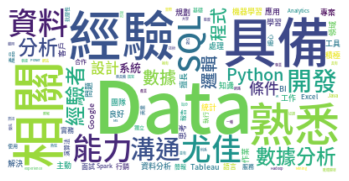

In [23]:
# 職缺其他條件分析
# 此處透過結巴TF-IDF斷詞來觀察重要詞彙
allKeyText = jieba.analyse.extract_tags('\n'.join(data['jobOthers'].tolist()), topK=100)

# 繪製文字雲
font = "NotoSansTC-Medium.otf"  # 使用Google開發的思源黑體字體
wordcloud = WordCloud(background_color="white", font_path=font).generate('.'.join(allKeyText))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()